In [1]:
import os
import pandas as pd
import numpy as np
from math import inf

def map_to_weight_range(value, thresholds, weights):
    """
    Map a parameter value to a weight based on defined thresholds and weights.
    
    Parameters:
        value: The parameter value to be mapped.
        thresholds: List of threshold values defining the ranges.
        weights: List of weights corresponding to each range.
    
    Returns:
        The weight corresponding to the range in which the value falls.
    """
    for i in range(len(thresholds) - 1):
        if thresholds[i] <= value < thresholds[i + 1]:
            return weights[i]
    
    # If value doesn't fall within any defined range, return default weight
    return weights[-1]

def extract_weights_mapped(X, thresholds, weights):
    """
    Extract weights based on mapping parameter values to weight ranges.
    
    Parameters:
        X: Feature matrix (parameters).
        thresholds: List of threshold values defining the ranges for each parameter.
        weights: List of weights corresponding to each range for each parameter.
    
    Returns:
        Array of weights for each parameter based on mapping.
    """
    mapped_weights = []
    for i in range(X.shape[1]):  # Iterate over each parameter
        parameter_values = X[:, i]
        parameter_weights = [map_to_weight_range(value, thresholds[i], weights[i]) for value in parameter_values]
        mapped_weights.append(parameter_weights)
    
    return np.array(mapped_weights).T

# Define thresholds and weights for each parameter
asu_thresholds = [0,10,20,30,40,45,50,55,60,65,inf]  # Adjusted thresholds for ASU
asu_weights = [0,0.15,0.30,0.39,0.48,0.57,0.66,0.75,0.84,0.93,1]  # Corresponding weights for poor, fair, normal, good, and excellent

rsrp_thresholds = [-120,-115,-117,-110,-108,-105,-102,-99 -95,-90 -87,-85 ,-80,-75,-70,-60, inf]  # Adjusted thresholds for RSRP
rsrp_weights = [0,0.1,0.2,0.3,0.35 ,0.4,0.45, 0.5,0.55,0.6,0.63,0.67,0,74,0.8,0.85,0.9, 1]  # Corresponding weights for poor, fair, normal, good, and excellent

rsrq_thresholds = [-20, -19, -17.5,-16,-14.5,-12.5,-11,-10,-9,-8,-7,-6,-5, inf]  # Adjusted thresholds for RSRQ
rsrq_weights = [0,0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.75,0.8,0.85,0.9, 1]  # Corresponding weights for poor, fair, normal, good, and excellent



# Combine thresholds and weights for all parameters
thresholds = [asu_thresholds, rsrp_thresholds, rsrq_thresholds ]
weights = [asu_weights, rsrp_weights, rsrq_weights]

# Directory where CSV files are located
directory = "plot"

# Iterate over CSV files in the directory
dfs = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        if filename.endswith(".csv"):
            filepath = os.path.join(root, filename)
            # Read CSV file and keep only specified columns
            df = pd.read_csv(filepath, usecols=['  currentTime', ' longitude', ' latitude', ' speed', ' rsrq', ' rsrp', ' asu'])
            
            # Convert relevant columns to numeric, coerce non-numeric values to NaN
            df[[' speed', ' rsrq', ' rsrp', ' asu']] = df[[' speed', ' rsrq', ' rsrp', ' asu']].apply(pd.to_numeric, errors='coerce')
            
            # Extract fractional seconds from the time and convert to float
            df['time_diff'] = pd.to_datetime(df['  currentTime']).dt.strftime('%S.%f').astype(float)
            
            # Calculate time difference between consecutive rows
            df['time_diff'] = df['time_diff'].shift(-10) - df['time_diff']
            
            # Calculate speed variation (acceleration)
            df['speed_variation'] = (df[' speed'].shift(-8) - df[' speed']) / df['time_diff']
            
            dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Drop rows where rsrq < -200
combined_df = combined_df[combined_df[' rsrq'] >= -200]

# Drop rows with NaN values
combined_df = combined_df.dropna()

# Add a new column 'signal_quality' based on the extracted weights
columns = [' asu', ' rsrp', ' rsrq']  # Adjusted column names
X = combined_df[columns].values

# Calculate mean weighted signal quality across parameters and assign to 'signal_quality' column
combined_df['signal_quality'] = extract_weights_mapped(X, thresholds, weights).mean(axis=1)

# Display the combined DataFrame
print(combined_df)


                   currentTime   longitude   latitude     speed   asu   rsrq  \
0      2023-10-08 11:13:55.215    6.275657  35.632591  0.709439    35    -14   
1      2023-10-08 11:13:55.245    6.275657  35.632591  0.709439    35    -14   
2      2023-10-08 11:13:55.352    6.275657  35.632591  0.709439    35    -14   
3       2023-10-08 11:13:55.45    6.275657  35.632591  0.709439    35    -14   
4      2023-10-08 11:13:55.549    6.275657  35.632591  0.709439    35    -14   
...                        ...         ...        ...       ...   ...    ...   
2975   2023-10-08 11:18:53.925    6.274598  35.630671  0.003974    32    -17   
2976   2023-10-08 11:18:54.022    6.274598  35.630672  0.021008    32    -17   
2977   2023-10-08 11:18:54.126    6.274598  35.630672  0.021008    32    -17   
2978   2023-10-08 11:18:54.227    6.274598  35.630672  0.021008    32    -17   
2979   2023-10-08 11:18:54.327    6.274598  35.630672  0.021008    32    -17   

       rsrp  time_diff  speed_variation

In [6]:
combined_df= combined_df[[ ' rsrq', ' rsrp', ' asu','signal_quality']]
print(combined_df)
print(combined_df.iloc[1900])

       rsrq   rsrp   asu  signal_quality
0       -14   -105    35        0.396667
1       -14   -105    35        0.396667
2       -14   -105    35        0.396667
3       -14   -105    35        0.396667
4       -14   -105    35        0.396667
...     ...    ...   ...             ...
2975    -17   -108    32        0.313333
2976    -17   -108    32        0.313333
2977    -17   -108    32        0.313333
2978    -17   -108    32        0.313333
2979    -17   -108    32        0.313333

[2980 rows x 4 columns]
 rsrq            -11.00
 rsrp            -94.00
 asu              46.00
signal_quality     0.54
Name: 1900, dtype: float64


In [14]:
import tensorflow as tf
from tensorflow import keras
from kerastuner import HyperModel, RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from keras_tuner import RandomSearch, HyperModel
import pandas as pd
import numpy as np
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt 


In [15]:
# Assume 'combined_df' is your dataset with features and target
feature_columns = [ ' rsrq', ' rsrp', ' asu']
target_column = 'signal_quality'

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df[feature_columns])

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_scaled)

# Target variable
y = combined_df[target_column].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Hypermodel definition for Keras Tuner
class MyRegressionHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        
        # Add input layer
        model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
        
        # Determine number of hidden layers and their activation functions
        num_layers = hp.Int('num_layers', 1, 3)  # Reduced maximum number of layers
        activation = hp.Choice('activation_function', ['relu', 'tanh', 'sigmoid'])
        
        # Regularization parameters
        l1_reg = hp.Choice('l1_regularization', [0.001, 0.01])  # Reduce options for regularization strengths
        l2_reg = hp.Choice('l2_regularization', [0.001, 0.01])
        
        for i in range(num_layers):
            # Define units for each hidden layer
            units = hp.Int(f'units_{i}', 16, 128, step=16)  # Reduce maximum number of units
            model.add(keras.layers.Dense(units, activation=activation, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
            
            # Optionally use dropout
            if hp.Boolean(f'use_dropout_{i}'):
                dropout_rate = hp.Float(f'dropout_rate_{i}', 0.2, 0.5)
                model.add(keras.layers.Dropout(rate=dropout_rate))
        
        # Output layer for regression
        model.add(keras.layers.Dense(1, activation='linear', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))  # Linear activation for regression
        
        # Define optimizer and learning rate
        optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])  # Removed 'adamw' option
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')  # Adjusted learning rate range

        if optimizer_name == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer_name == 'rmsprop':
            optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
        
        # Compile with MSE loss
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])
        
        return model

# Set up the tuner for hyperparameter tuning
tuner = RandomSearch(
    MyRegressionHyperModel(),
    objective='val_loss',  # Optimize for lowest validation loss
    max_trials=20,  # Number of different hyperparameter sets to test
    executions_per_trial=1,  # Number of times each trial is executed
    directory='tuning_results_regression',  # Directory for tuning results
    project_name='signal_quality_regression',  # Project name
    overwrite=True  # Overwrite existing tuning results if any
)

# Start the hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,  # Use 20% of training data for validation
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)  # Early stopping
    ],
    verbose=1  # Level of verbosity for the search
)

# Retrieve the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Train the best model using optimal hyperparameters
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)],
    verbose=1
)

# Evaluate on the test set
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print("Test set MSE:", test_mse)


Trial 20 Complete [00h 01m 19s]
val_loss: 0.005180676933377981

Best val_loss So Far: 0.003409012220799923
Total elapsed time: 00h 23m 28s
Best hyperparameters:
num_layers: 1
activation_function: tanh
l1_regularization: 0.001
l2_regularization: 0.01
units_0: 48
use_dropout_0: True
optimizer: rmsprop
learning_rate: 0.00018306931312054623
dropout_rate_0: 0.2
Epoch 1/20
1364/1364 [==============================] - 6s 4ms/step - loss: 0.1192 - mse: 0.0491 - val_loss: 0.0327 - val_mse: 6.8787e-04
Epoch 2/20
1364/1364 [==============================] - 4s 3ms/step - loss: 0.0144 - mse: 0.0021 - val_loss: 0.0056 - val_mse: 0.0011
Epoch 3/20
1364/1364 [==============================] - 3s 3ms/step - loss: 0.0055 - mse: 0.0017 - val_loss: 0.0044 - val_mse: 0.0010
Epoch 4/20
1364/1364 [==============================] - 4s 3ms/step - loss: 0.0046 - mse: 0.0015 - val_loss: 0.0039 - val_mse: 0.0010
Epoch 5/20
1364/1364 [==============================] - 6s 4ms/step - loss: 0.0041 - mse: 0.0014 - va

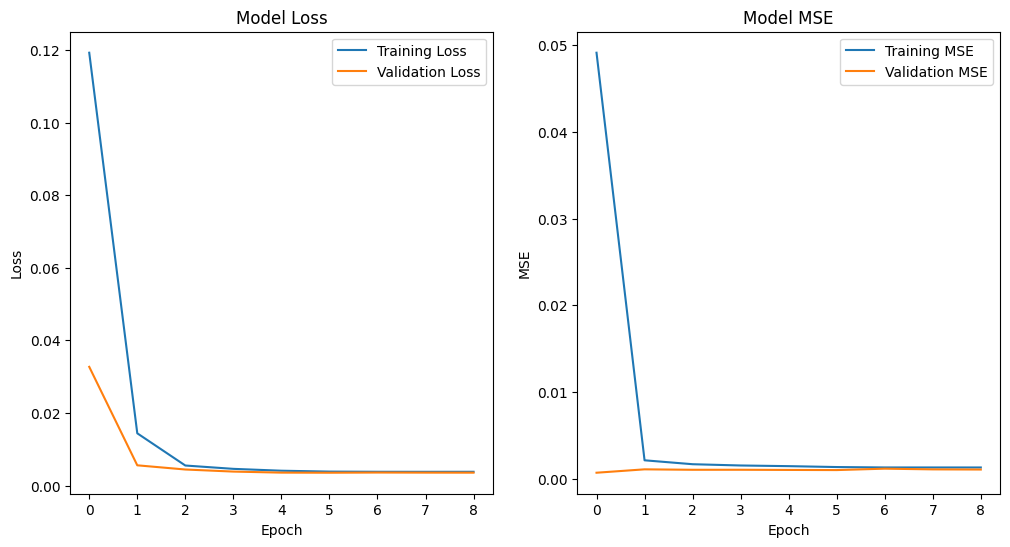

In [23]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MSE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [26]:
# Save the trained model to a specified location
model_save_path = 'Newest_best_model.h5'  # You can use '.h5' or SavedModel format
best_model.save(model_save_path)

print("The model is has been saved") 

The model is has been saved


427/427 [==============================] - 1s 1ms/step


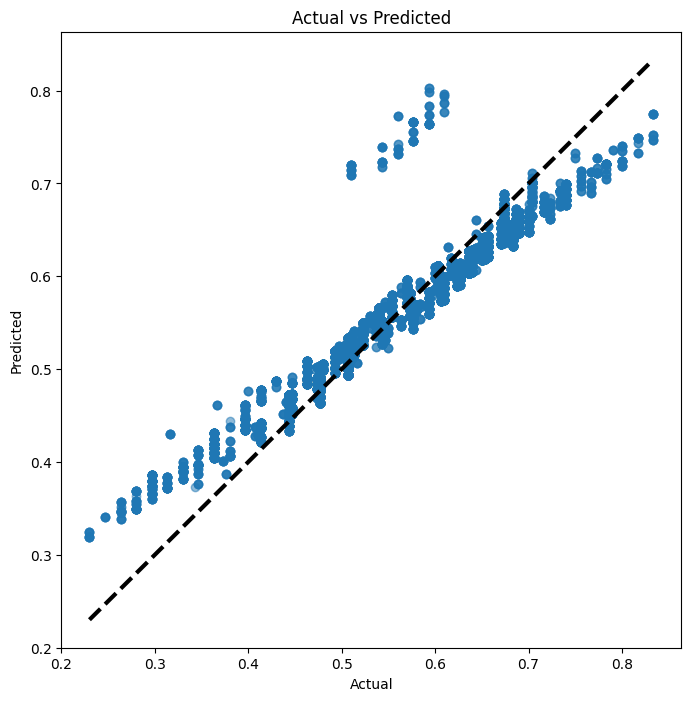

In [27]:
# Get predictions on the test set
y_pred = best_model.predict(X_test)

# Plot actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()


427/427 [==============================] - 1s 2ms/step


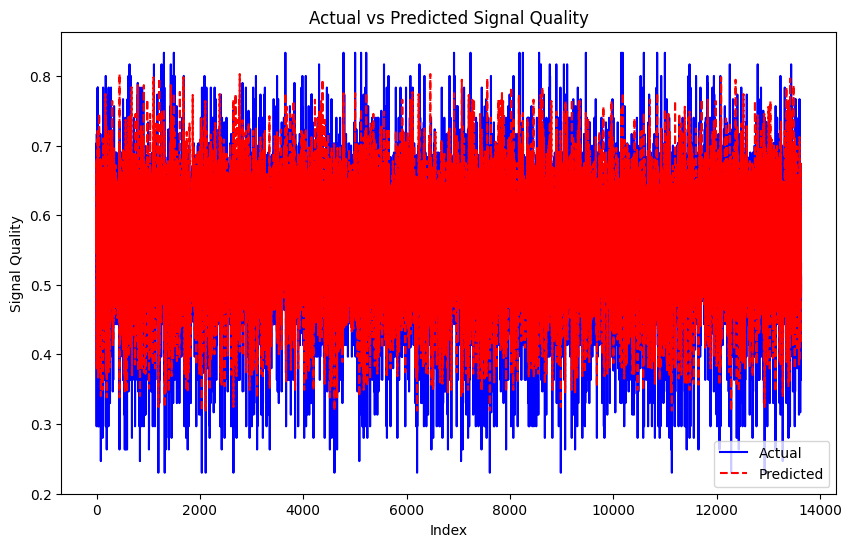

In [28]:
import matplotlib.pyplot as plt

# Get predictions on the test set
y_pred = best_model.predict(X_test)

# Plot predicted data and real data on the same graph with different curves
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Index')
plt.ylabel('Signal Quality')
plt.title('Actual vs Predicted Signal Quality')
plt.legend()
plt.show()
